# Simple CNN ( Kent Chiu )
### Introduction


In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import os, sys, progressbar, argparse 
import commentjson as json

from imutils import paths
from skimage.io import imread
import imageio
import cv2

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json

Using Theano backend.
INFO (theano.gof.compilelock): Waiting for existing lock by process '22752' (I am process '20532')
INFO (theano.gof.compilelock): To manually release the lock, delete C:\Users\kentc\AppData\Local\Theano\compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.12-64\lock_dir
DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.12-64/cuda_ndarray/cuda_ndarray.lib and object C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.12-64/cuda_ndarray/cuda_ndarray.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.12-64/tmpmjdtj3/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/kentc/AppData/Local/Theano/compiledir_Windows-10-10.0.1

### Define CNN Architectures

In [2]:

def simpleNN(nb_classes,img_rows,img_cols,img_channels):
    #####Fail
    model = Sequential()
    model.add(Dense(512, input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    return model

def simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols,img_channels, Dense_Before_Out=12):
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    
    model.add(Dense(Dense_Before_Out))
    model.add(Activation('tanh'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    return model


def simpleCNN_2(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols,img_channels, Dense_Before_Out=32):
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('tanh'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    
    model.add(Dense(10*Dense_Before_Out, init='lecun_uniform'))
    model.add(Activation('tanh'))    
    
    model.add(Dense(Dense_Before_Out, init='lecun_uniform'))
    model.add(Activation('tanh'))
    
    model.add(Dense(nb_classes, init='lecun_uniform'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
    return model



def simpleCNN_3(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols,img_channels, Dense_Before_Out=520):
    model = Sequential()
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_channels, img_rows, img_cols)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(Dense_Before_Out,))
    model.add(Activation('tanh'))
    
    model.add(Dropout(0.25))
    model.add(Dense(Dense_Before_Out,))
    model.add(Activation('tanh'))
    
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))
    #sgd = SGD(lr=1e-2, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
    return model

# Clean the dataset 
## ImageFolder_Name



In [3]:

class Conf:
    def __init__(self, confPath):
        # load and store the configuration and update the object's dictionary
        conf = json.loads(open(confPath).read())
        self.__dict__.update(conf)

    def __getitem__(self, k):
        # return the value associated with the supplied key
        return self.__dict__.get(k, None)
    
    
def auto_resized(img,size):
    '''size = (width,height)'''
    size = tuple(size)
    resize_img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return resize_img


def TrainFilePath(folderPath, constrain=None, **kargs):
    '''
    (1) Output filepath and calssName
    (2) folderPath 
          --label_1
           -- xxx.jpg
    '''
    assert folderPath[-1]!='/'
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg') 
    for (rootDir, dirNames, fileNames) in os.walk(folderPath):
        for fileName in fileNames:
            if fileName.split('.')[-1] in constrain:
                yield (os.path.join(rootDir, fileName)) 

#img_channels = 3
def genTrX(filePath, resolution, img_channels=3):
    assert type(resolution) == tuple
    img = auto_resized(imread(filePath),resolution)  #conf['sliding_size']
    if img_channels==1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img_channels==3:
        img = img[:,:,:3]
    return img

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def load_training(folderList):
    TrY = []
    TrX = []
    TrY_template = np.eye(len(folderList))
    for eyeId, folderPath in enumerate(folderList):
        for imgPath in TrainFilePath(folderPath) :
            TrY.append(TrY_template[eyeId])
            TrX.append(genTrX(imgPath, (img_rows,img_cols), img_channels))
    print (len(TrX))
    return TrX, TrY

def reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels):
    trainX = np.asarray(TrX, dtype = np.uint8)
    trainX = trainX.reshape(trainX.shape[0], img_channels, img_rows, img_cols)
    trainX = trainX.astype('float32')
    trainY = np.asarray(TrY, dtype = np.float32)
    # shuffle
    trainX , trainY = shuffle(trainX,trainY)
    print ('Train_X : ',trainX.shape,'Train_Y' ,trainY.shape)
    return trainX , trainY

## Configuration of data

### Dataset
##### [-]  SkewDriver D:\2D_DataSet\PureScrewDriver
##### [-]  Hands D:\2D_DataSet\Rhand_v2
##### [-]  D:\2D_DataSet\RHwithScrewDriver

### 數據越複雜,模型才越複雜
### 模型越複雜,EPOCH 才多一點,...etc


In [5]:
if os.name=='nt':
    foler_list = ['D:\\2D_DataSet\\PureScrewDriver', 'D:\\2D_DataSet\\Rhand_v2']
else:
    foler_list = ['/Users/kentchiu/MIT_Vedio/2D_DataSet/PureScrewDriver', '/Users/kentchiu/MIT_Vedio/2D_DataSet/Rhand_v2']

img_rows = 30
img_cols = 30
img_channels = 1
nb_classes = len(foler_list)

batch_size = 1

# EPOCH SENEITIVE ...
nb_epoch = 10

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

##############
# Clean Data # 
##############
model = simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
model = simpleCNN_3(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
TrX, TrY = load_training(foler_list)
trainX , trainY = reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels=img_channels)




#Tr_X, Te_X, Tr_Y, Te_Y = train_test_split(trainX, trainY, test_size=0.2, random_state=0)
#print ("Training and testing split was successful.")


151
Train_X :  (151L, 1L, 30L, 30L) Train_Y (151L, 2L)


### Training Model

In [6]:
%%capture

# Training without cross-validation
#model.fit(Tr_X, Tr_Y, batch_size=batch_size, nb_epoch=nb_epoch,
#          verbose=1, validation_data=(Te_X, Te_Y))

# Training with cross-validation but...?
kf = KFold(len(trainY), n_folds=5)
for train, test in kf:
    #print (train, test)
    Tr_X = trainX[train]
    Te_X = trainX[test]
    Tr_Y = trainY[train]
    Te_Y = trainY[test]

    #fit model and score
    model.fit(Tr_X, Tr_Y, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(Te_X, Te_Y))



### Evaluation Model

In [7]:
score = model.evaluate(Te_X, Te_Y, verbose=0)

#model.save('../hub/model/0907_2.h5')
from datatime import datetime 

model_name= str(datetime.now().split(' ')[0])

model.save_weights('../hub/model/{}.h5'.format(model_name))
print('Test score:', score[0])
print('Test accuracy:', score[1])
print(model.summary())


for x in range(40,50):
    print ('----------------------------------------------------------')
    print (model.predict(Tr_X[x].reshape(1,img_channels,img_rows,img_rows)) )
    print (model.predict_classes(Tr_X[x].reshape(1,img_channels,img_rows,img_rows)) ,'--><--', np.argmax(Tr_Y[x]) )

# serialize model to JSON
model_json = model.to_json()
with open("../hub/model/{}.json".format(model_name), "w") as json_file:
    json_file.write(model_json)


Test score: 6.82763214854e-08
Test accuracy: 1.0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '7000' (I am process '20532')


convolution2d_3 (Convolution2D)  (None, 32, 28, 28)    320         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 32, 28, 28)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 32, 26, 26)    9248        activation_5[0][0]               
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 32, 26, 26)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 32, 13, 13)    0           activation_6[0][0]               
___________________________________________________________________________________________

### Further Interaction 

[[  5.30674810e-11   1.00000000e+00]]
1/1 [==============================] - 0s
[1] --><-- 1


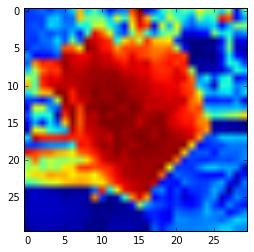

In [8]:

#print (Te_Y)

from ipywidgets import interact, interactive, fixed
from ipywidgets import widgets

def f(x):
    
    #plt.imshow(Tr_X[x].reshape(img_rows,img_rows,3)) # color
    plt.imshow(Tr_X[x].reshape(img_rows,img_rows)) # gray
    print (model.predict(Tr_X[x].reshape(1,img_channels,img_rows,img_rows)) )
    print (model.predict_classes(Tr_X[x].reshape(1,img_channels,img_rows,img_rows)) ,'--><--', np.argmax(Tr_Y[x]) )

interact(f,x = 20)
#for i in range(12):
#    f(i)

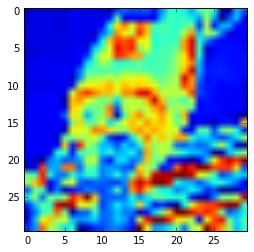

In [9]:
x = 10
img = Tr_X[x].reshape(img_rows,img_rows)
plt.imshow(img)
    #raw_input("Press Enter to continue...") #python2

### Model Loading and Reuse

In [ ]:

class ConvNetFactory:
	def __init__(self):
		pass

	@staticmethod
	def build(name, *args, **kargs):
		# define the network (i.e., string => function) mappings
		mappings = {
			"shallownet": ConvNetFactory.ShallowNet,
			"lenet": ConvNetFactory.LeNet,
			"karpathynet": ConvNetFactory.KarpathyNet,
			"minivggnet": ConvNetFactory.MiniVGGNet}

		# grab the builder function from the mappings dictionary
		builder = mappings.get(name, None)

		# if the builder is None, then there is not a function that can be used
		# to build to the network, so return None
		if builder is None:
			return None

		# otherwise, build the network architecture
		return builder(*args, **kargs)

	@staticmethod
	def ShallowNet(numChannels, imgRows, imgCols, numClasses, **kwargs):
		# initialzie the model
		model = Sequential()

		# define the first (and only) CONV => RELU layer
		model.add(Convolution2D(32, 3, 3, border_mode="same",
			input_shape=(numChannels, imgRows, imgCols)))
		model.add(Activation("relu"))

		# add a FC layer followed by the soft-max classifier
		model.add(Flatten())
		model.add(Dense(numClasses))
		model.add(Activation("softmax"))

		# return the network architecture
		return model

	@staticmethod
	def LeNet(numChannels, imgRows, imgCols, numClasses, activation="tanh", **kwargs):
		# initialize the model
		model = Sequential()

		# define the first set of CONV => ACTIVATION => POOL layers
		model.add(Convolution2D(20, 5, 5, border_mode="same",
			input_shape=(numChannels, imgRows, imgCols)))
		model.add(Activation(activation))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# define the second set of CONV => ACTIVATION => POOL layers
		model.add(Convolution2D(50, 5, 5, border_mode="same"))
		model.add(Activation(activation))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# define the first FC => ACTIVATION layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation(activation))

		# define the second FC layer
		model.add(Dense(numClasses))

		# lastly, define the soft-max classifier
		model.add(Activation("softmax"))

		# return the network architecture
		return model

	@staticmethod
	def KarpathyNet():
		# initialize the model
		model = Sequential()

		# define the first set of CONV => RELU => POOL layers
		model.add(Convolution2D(16, 5, 5, border_mode="same",
			input_shape=(numChannels, imgRows, imgCols)))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.25))

		# define the second set of CONV => RELU => POOL layers
		model.add(Convolution2D(20, 5, 5, border_mode="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.25))

		# define the third set of CONV => RELU => POOL layers
		model.add(Convolution2D(20, 5, 5, border_mode="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.5))

		# define the soft-max classifier
		model.add(Flatten())
		model.add(Dense(numClasses))
		model.add(Activation("softmax"))

		# return the network architecture
		return model

	@staticmethod
	def MiniVGGNet():
		# initialize the model
		model = Sequential()

		# define the first set of CONV => RELU => CONV => RELU => POOL layers
		model.add(Convolution2D(32, 3, 3, border_mode="same",
			input_shape=(numChannels, imgRows, imgCols)))
		model.add(Activation("relu"))
		model.add(Convolution2D(32, 3, 3))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.25))

		# define the second set of CONV => RELU => CONV => RELU => POOL layers
		model.add(Convolution2D(64, 3, 3, border_mode="same"))
		model.add(Activation("relu"))
		model.add(Convolution2D(64, 3, 3))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.25))

		# define the set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))

		# check to see if dropout should be applied to reduce overfitting
		if dropout:
			model.add(Dropout(0.5))

		# define the soft-max classifier
		model.add(Dense(numClasses))
		model.add(Activation("softmax"))

		# return the network architecture
		return model

In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print "%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100)

# LOG

- nb_filters = 32,64,128....etc
- lr = 1e-2, 1e-3,1e-4

- model.add(Activation('tanh'))
- model.add(Activation('relu'))...etc
- remove dropout
- shrink the neurno size


In [ ]:

from sklearn.cross_validation import train_test_split
# loopover distraction_dir and slinding_window


def TrainFilePath(folderList, constrain=None, **kargs ):
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg')
    for basePath in folderList :
        for (rootDir, dirNames, fileNames) in os.walk(basePath):
            for fileName in fileNames:
                if fileName.split('.')[-1] in constrain:
                    yield os.path.join(rootDir, fileName), rootDir
                    
def sliding_window(image, stepSize, winSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
                yield (x, y, image[y:y + winSize[1], x:x + winSize[0]])
                
                
def pos_extract(conf):
    # grab the set of ground-truth images and select a percentage of them for training
    trnPaths = list(paths.list_images(conf["pos_raw_ph"]))
    assert len(trnPaths)!=0
    #
    if not os.path.isdir(conf['pos_feat_ph']):
        os.makedirs(conf['pos_feat_ph'])

    # setup the progress bar
    widgets = ["Extracting: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
    for (i, imgPath) in enumerate(trnPaths):
        # img = imread(imgPath)
        # resize to the training resolution (wid,height)
        img = auto_resized(imread(imgPath, as_grey=True),conf['sliding_size'])
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        ##############################################################################
        fd=hog(img, conf['orientations'], conf['pixels_per_cell'], 
                    conf['cells_per_block'], conf['visualize'], conf['normalize'])
        fd_name = os.path.split(imgPath)[1].split(".")[0] + ".feat"
        fd_path = os.path.join(conf['pos_feat_ph'], fd_name)
        joblib.dump(fd, fd_path)
        pbar.update(i)
    pbar.finish()
    print ('[*] Finished Pos.')


def extract(conf):
    # grab the set of ground-truth images and select a percentage of them for training
    trnPaths = list(paths.list_images(conf["neg_raw_ph"]))
    assert len(trnPaths)!=0
    #
    if not os.path.isdir(conf['neg_feat_ph']):
        os.makedirs(conf['neg_feat_ph'])
    # setup the progress bar
    widgets = ["Extracting: ", progressbar.Percentage(), " ",
        progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(maxval=len(trnPaths), widgets=widgets).start()
    for (i, imgPath) in enumerate(trnPaths):
        # img = imread(imgPath)
        # resize to the training resolution (wid,height)
        img = auto_resized(imread(imgPath, as_grey=True),conf['train_resolution'])
        #######################################################
        # if some pos_img in neg_img with stationary position #
        #######################################################
        if conf['special_cover'] is not None:
            print ('[*] Triggerd special_cover')
            startX,startY,endX,endY = conf['special_cover']
            cv2.rectangle(img, (startX-10,startY-10), (endX+10,endY+10), 0, -1) 
            #################################
            # -1 = filled, 0 = outline only #
            #################################
        fd_id=0 #just a index for recording feature_file
        for x,y,window in sliding_window(img, conf['step_size'],conf['sliding_size']):
            if window.shape != tuple(conf['sliding_size']):
                pass
            else :
                fd=hog(window, conf['orientations'], conf['pixels_per_cell'], 
                    conf['cells_per_block'], conf['visualize'], conf['normalize'])
                fd_name = os.path.split(imgPath)[1].split(".")[0] +str(fd_id)+ ".feat"
                fd_path = os.path.join(conf['neg_feat_ph'], fd_name)
                joblib.dump(fd, fd_path)
                fd_id+=1
        pbar.update(i)
    pbar.finish()
    print ('[*] Finished Neg.')
